In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from pmdarima import auto_arima
import statsmodels as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
pip install pmdarima

Read data for the location of Berlin and visualize the time series

In [165]:
df = pd.read_csv('2021-05-16_LK_cases.csv',index_col='target', parse_dates=True)
#df.index = pd.to_datetime(df['target'], format='%Y-%m-%d')
df=df[df.location==11001].dropna().drop('location', axis=1)
len(df)


470

<AxesSubplot: xlabel='target'>

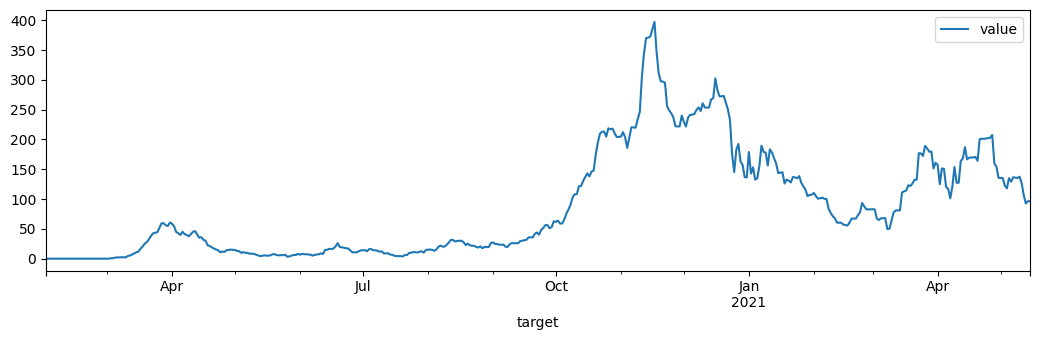

In [125]:
df.plot()

Split in train and test data  

470
                 value
target                
2021-05-11  127.342284
2021-05-12  106.785982
2021-05-13   92.636840
2021-05-14   96.374349
2021-05-15   96.374349
440 30


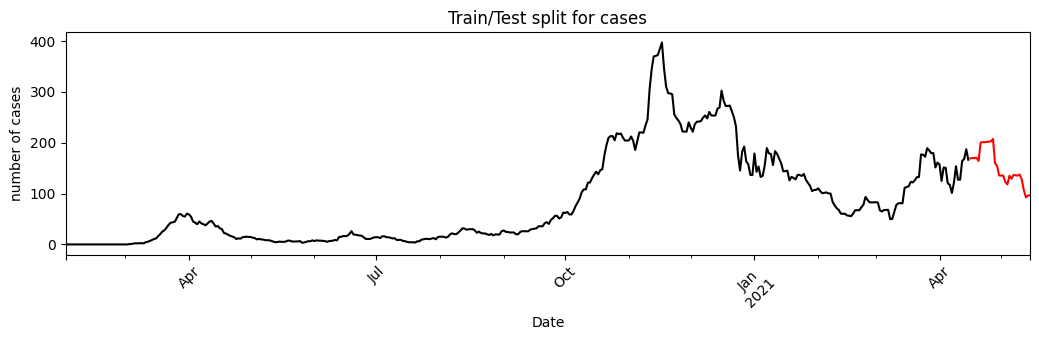

In [129]:
plt.rcParams["figure.figsize"] = [10.50, 3.50]
plt.rcParams["figure.autolayout"] = True

#df.target=pd.to_datetime(df['target'])
print(len(df))
print(df.tail())

# train = df[df.target<datetime(2021, 4, 17)]
# test = df[df.target>datetime(2021, 4, 17)]

train = df.iloc[:440]
test = df.iloc[440:]

print(len(train), len(test))
train.value.plot(color='black')
test.value.plot(color='red')
plt.ylabel('number of cases')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for cases")
plt.show()



1. Perform ARIMA regression for this time series data

In [85]:
result = auto_arima(train.value, seasonal=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2735.183, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2798.561, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2797.577, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2798.295, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2796.708, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2773.214, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2780.633, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2737.017, Time=0.30 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2733.830, Time=0.94 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2763.253, Time=0.43 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2727.876, Time=0.73 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=2741.017, Time=0.77 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.15 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.07 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=2

In [86]:
model = SARIMAX(train['value'], order=(3,1,3))
result = model.fit()

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.14843D+00    |proj g|=  2.16980D-01

At iterate    5    f=  3.12491D+00    |proj g|=  4.17572D-01

At iterate   10    f=  3.07915D+00    |proj g|=  1.36223D-02

At iterate   15    f=  3.07566D+00    |proj g|=  1.25520D-02

At iterate   20    f=  3.07534D+00    |proj g|=  2.23814D-02

At iterate   25    f=  3.07494D+00    |proj g|=  7.02850D-03

At iterate   30    f=  3.07475D+00    |proj g|=  1.61558D-03

At iterate   35    f=  3.07475D+00    |proj g|=  5.75318D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

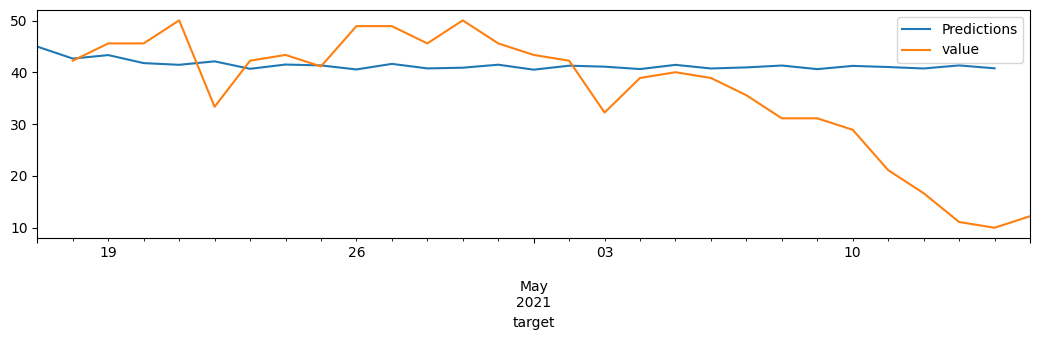

28
28


In [89]:
start = len(train)
end = len(train)+len(test)-1

pred = result.predict(start=start, end=end, typ='levels', dynamic=False).rename('Predictions')

#test.value.plot()
pred.plot(legend=True)
test.value.plot(legend=True)
plt.show()

print(len(pred))
print(len(test.values))

2. Perform Linear Regression for the time series

r =  0.6433958984441368 
 p =  2.831946327349688e-56 
 s =  2.678274569185638e-16


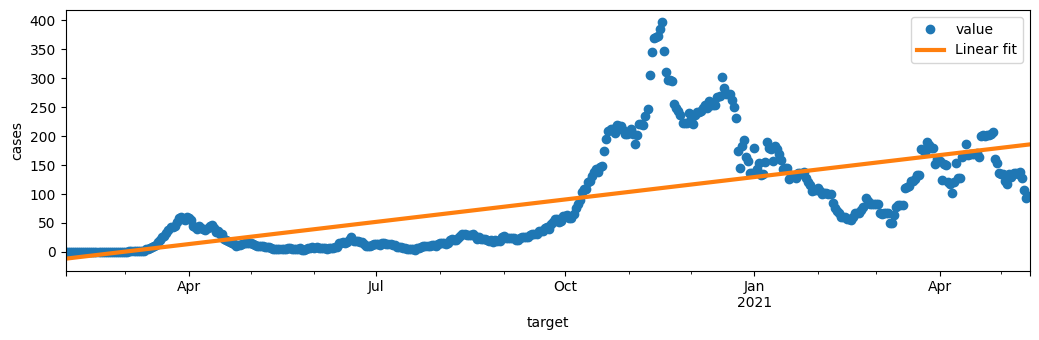

In [71]:
import scipy.stats as sp
y=np.array(df[df.location==11001]['value'].dropna().values, dtype=float)
x=np.array(df[df.location==11001]['target'].dropna().index.values, dtype=float)
slope, intercept, r_value, p_value, std_err =sp.linregress(x,y)
xf = np.linspace(min(x),max(x),100)
xf1 = xf.copy()
xf1 = pd.to_datetime(xf1)
yf = (slope*xf)+intercept
print('r = ', r_value, '\n', 'p = ', p_value, '\n', 's = ', std_err)
f, ax = plt.subplots(1, 1)
df[df.location==11001]['value'].dropna().plot(ax=ax,marker='o', ls='')
ax.plot(xf1, yf,label='Linear fit', lw=3)

plt.ylabel('cases')
ax.legend();

3. RNN Implementation for the time series data

In [166]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scale the values between 0 and 1

In [131]:
scaler.fit(train)
scaled_train=scaler.transform(train)
scaled_test=scaler.transform(test)

scaled_train[-10:]

array([[0.29502688],
       [0.2547043 ],
       [0.30510753],
       [0.38709677],
       [0.32056452],
       [0.32056452],
       [0.41263441],
       [0.4233871 ],
       [0.47110215],
       [0.41935484]])

Prepare the RNN model

In [152]:
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM

n_input = 30
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100)               40800     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


Fit the RNN model on the training data

In [153]:
model.fit(generator, epochs=50)

Epoch 1/50
410/410 [==============================] - 4s 9ms/step - loss: 0.0060
Epoch 2/50
410/410 [==============================] - 4s 9ms/step - loss: 0.0039
Epoch 3/50
410/410 [==============================] - 4s 9ms/step - loss: 0.0022
Epoch 4/50
410/410 [==============================] - 4s 9ms/step - loss: 0.0018
Epoch 5/50
410/410 [==============================] - 3s 8ms/step - loss: 0.0014
Epoch 6/50
410/410 [==============================] - 4s 9ms/step - loss: 0.0012
Epoch 7/50
410/410 [==============================] - 3s 8ms/step - loss: 0.0013
Epoch 8/50
410/410 [==============================] - 4s 9ms/step - loss: 0.0015
Epoch 9/50
410/410 [==============================] - 4s 9ms/step - loss: 0.0011
Epoch 10/50
410/410 [==============================] - 4s 9ms/step - loss: 0.0012
Epoch 11/50
410/410 [==============================] - 3s 8ms/step - loss: 0.0011
Epoch 12/50
410/410 [==============================] - 4s 9ms/step - loss: 0.0013
Epoch 13/50
410/410 [====

Plot loss per epoch from the training phase

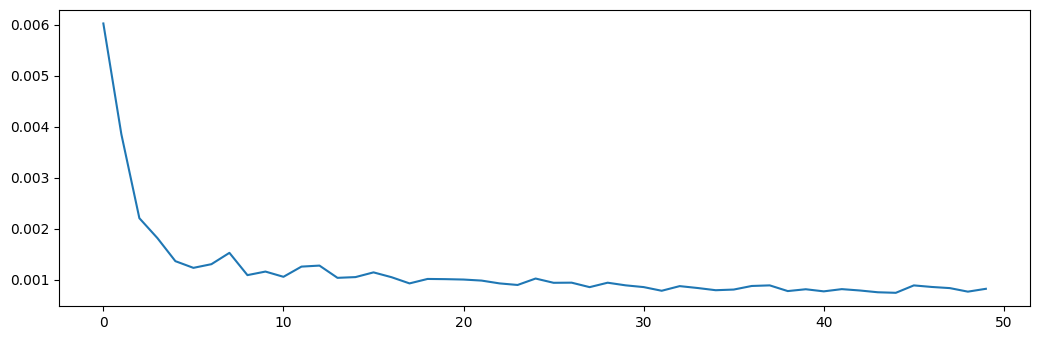

In [154]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

Perform prediction for the test data

In [158]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 18ms/step


Rescale the predicted values to get the actual true predictions and plot them with the test data

                 value  Predictions
target                             
2021-04-16  169.255782   173.841056
2021-04-17  169.789712   182.602695
2021-04-18  169.789712   186.754204
2021-04-19  170.590607   189.398989
2021-04-20  164.183448   191.386982


/tmp/ipykernel_16/4218538613.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<AxesSubplot: xlabel='target'>

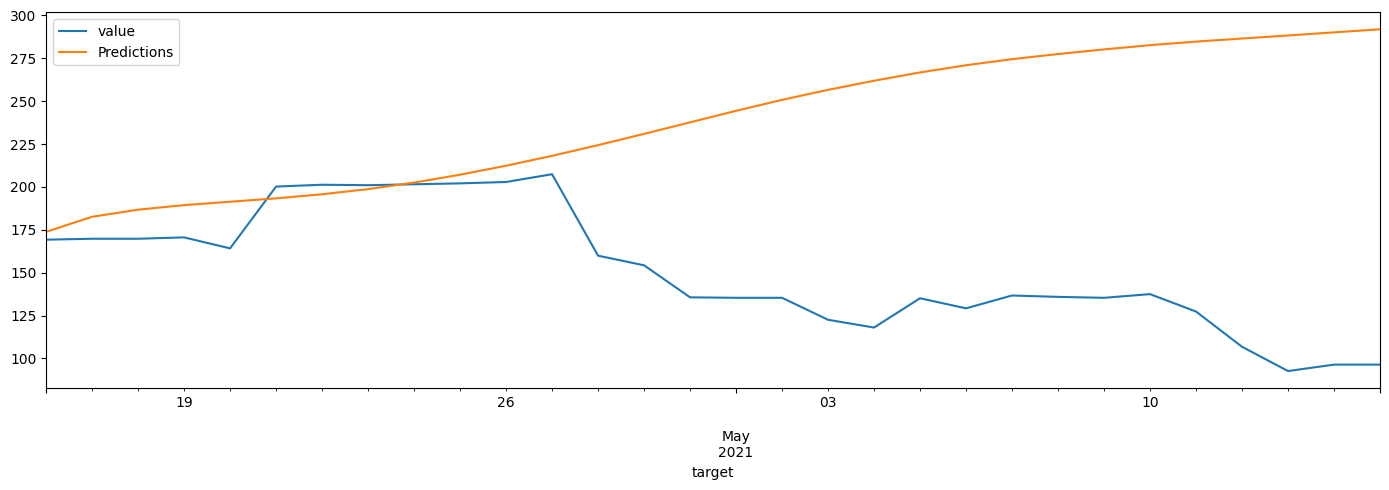

In [162]:
true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions
print(test.head())
test.plot(figsize=(14,5))

Calculate the root mean squared error

In [164]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['value'],test['Predictions']))
print(rmse)

111.95787084361339
